# Sistemas Híbridos

Atividade referente ao assunto Sistemas Híbridos. 

O objetivo dessa atividade foi implementar um Sistema Híbirdo, conforme Zhang (2003), para realizar previsão do logaritmo da taxa de mortalidade da idade de 40 anos da população francesa. 

A metodologia consiste em realizar a modelagem da série $Z_t$ a partir da equação $Z_t=L_t + N_t$.  
Para tanto, utilizou-se um Arima(p,d,q) para modelar $L_t$, enquanto que a estrutura não linear, $N_t$, foi modelada pelas Redes Neurais Artificiais, especificamente por uma Multilayer Perceptron (MLP).

O trabalho está dividido em: 
* Funções implementadas
* Carregamento das bibliotecas
* Importação dos dados
* Análise gráfica e estatística da série temporal
* ARIMA
* MLP
* Aplicação do Sistema Híbrido - ARIMA + MLP

#### Funções implementadas

In [1]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y

In [2]:
def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return pd.DataFrame(serie)

In [3]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
            
    return janelas_np

In [4]:
def diferenciar_serie(serie):
    #serie: obj pandas
    return serie.diff().dropna()

In [5]:
def incrementar_serie(serie_real, serie_diff):
    return serie_real[0:-1] + serie_diff

In [6]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]
    
    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)
       
    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x
    
    lags_selecionados = []
    
    for i in range(1, max_lag+1):

        
        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0
    
    #caso nenhum lag seja selecionado, essa atividade de seleção para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

In [7]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

### Carregando biblioteca

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE
from pmdarima import auto_arima
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6

/home/ggcarvalho/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/ggcarvalho/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [9]:
import os
os.chdir("/Users/filipeduarte/Documents/Mortality_data")
os.getcwd()

'/Users/filipeduarte/Documents/Mortality_data'

### Importação dos dados

In [13]:
# importing data
lnmx_series = pd.read_csv('lnmx_series.csv', sep = ',', index_col = 0)
lnmx_series.head()

,0,1,2,5,10,12,15,18,20,22,25,28,30,40,50,60,70,80,90,100
Year,,,,,,,,,,,,,,,,,,,,
1816,-1.583074,-3.064332,-3.377842,-4.287954,-5.091791,-5.344152,-5.227673,-4.898736,-4.720806,-4.601178,-4.580380,-4.682375,-4.678817,-4.431805,-4.019219,-3.380601,-2.652838,-1.813196,-1.471469,-1.039535
1817,-1.608114,-2.917439,-3.250650,-4.178923,-5.048181,-5.240992,-5.115163,-4.873834,-4.696518,-4.641212,-4.641834,-4.720357,-4.697505,-4.393209,-3.957125,-3.337293,-2.654088,-1.835461,-1.475817,-0.584203
1818,-1.601852,-2.794409,-3.181171,-4.111145,-4.999844,-5.203553,-5.079503,-4.841906,-4.676129,-4.603172,-4.639865,-4.684863,-4.645680,-4.389253,-3.987016,-3.382189,-2.689837,-1.894510,-1.497753,-0.489103
1819,-1.532375,-2.709036,-3.081486,-4.009581,-4.854401,-5.175923,-5.117664,-4.838112,-4.671951,-4.554287,-4.626700,-4.658044,-4.622723,-4.386035,-3.974377,-3.403791,-2.718570,-1.903165,-1.486446,-0.719076
1820,-1.622807,-2.861656,-3.217926,-4.133169,-4.927030,-5.293131,-5.237787,-4.909931,-4.752858,-4.633775,-4.728242,-4.756226,-4.692036,-4.425435,-3.968329,-3.370368,-2.669195,-1.794227,-1.418202,-0.639684


In [11]:
import os
os.chdir("/Users/filipeduarte/Desktop/TimeSeriesCin-master")
os.getcwd()

'/Users/filipeduarte/Desktop/TimeSeriesCIn-master'

#### Análise gráfica e estatística

In [14]:
idades = lnmx_series.columns

In [15]:
# Começar com a idade 40 anos
lnmx = lnmx_series['40']

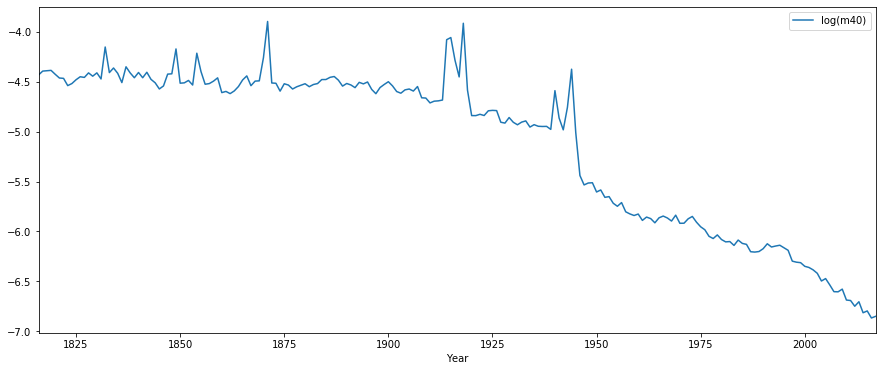

In [16]:
# gráfico 
lnmx.plot(label='log(m40)')
plt.legend()
plt.show()

Verifica-se um comportamento muito distinto a partir do ano de 1950. 

Sendo assim, optou-se por utilizar a série a partir dessa data até 2017.

In [17]:
# selecionar a partir de 1950
lnmx = lnmx.loc[1950:]

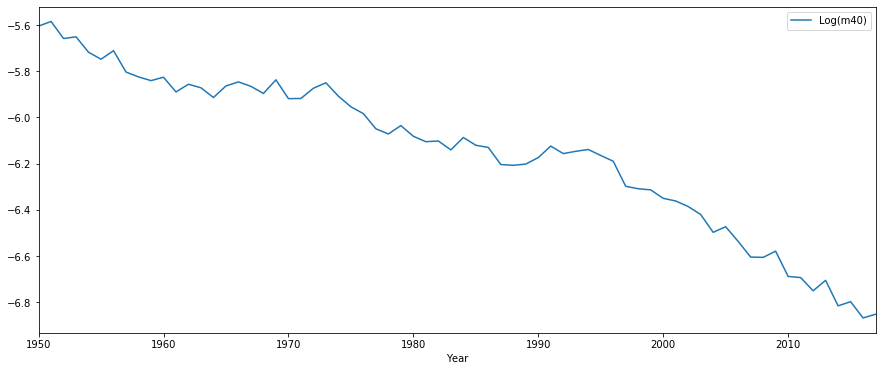

In [18]:
# verificar o gráfico novamente
lnmx.plot(label='Log(m40)')
plt.legend()
plt.show()

In [19]:
# Seperar os dados em treinamento e teste. 
treino = lnmx.loc[1950:1997]
teste = lnmx.loc[1998:]

* Treinamento: 1950-1997
* Teste: 1998-2017

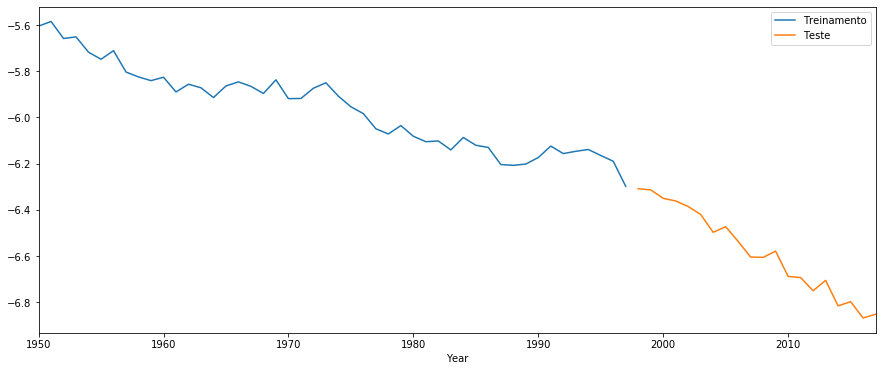

In [20]:
# Visualizar o gráfico 
treino.plot(label = 'Treinamento')
teste.plot(label='Teste')
plt.legend()
plt.show()

In [21]:
# calcular as estatísticas
treino.describe()

count    48.000000
mean     -5.961239
std       0.181379
min      -6.297990
25%      -6.125342
50%      -5.918214
75%      -5.844773
max      -5.584667
Name: 40, dtype: float64

In [22]:
teste.describe()

count    20.000000
mean     -6.579912
std       0.186137
min      -6.867573
25%      -6.716085
50%      -6.591203
75%      -6.411191
max      -6.308369
Name: 40, dtype: float64

In [23]:
# Analisar a estacionariedade da série de treinamento
result = adfuller(treino)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.938376
p-value: 0.775072
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


Resultados indicam que a série é não estacionária. Dessa maneira, temos que realizar a diferenciação pelo modelo Arima.
Próximo passo será analisar o autocorrelograma/parcial da série de treinamento diferenciada.

/home/ggcarvalho/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


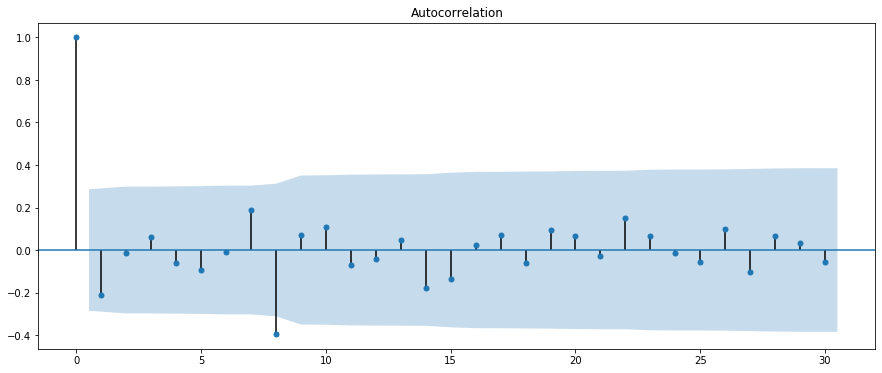

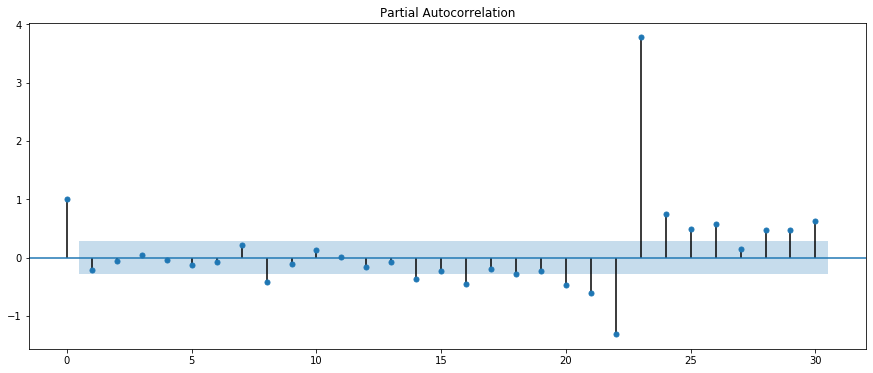

In [24]:
plot_acf(treino.diff().dropna(), lags=30)
plot_pacf(treino.diff().dropna(), lags = 30)
plt.show()

Não se verifica autocorrelação nem média móvel de forma expressiva. Usaremos o auto-arima para verificar qual seria o modelo com melhor AIC.

### ARIMA

Utilizou-se o auto_arima da biblioteca pyramid.arima para modelar a série de treinamento. 

O auto_arima busca o modelo com o menor AIC, a partir de uma busca iniciando com os parâmetros pelos modelos mais parcimoniosos.

In [25]:
stepwise_model = auto_arima(treino, start_p=1, start_q=1,
                           max_p=10, max_q=10, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1); AIC=-161.158, BIC=-153.758, Fit time=1.069 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-162.541, BIC=-158.840, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-162.965, BIC=-157.414, Fit time=0.044 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-163.158, BIC=-157.607, Fit time=0.021 seconds
Fit ARIMA: order=(0, 1, 2); AIC=-161.158, BIC=-153.758, Fit time=0.039 seconds
Fit ARIMA: order=(1, 1, 2); AIC=-161.274, BIC=-152.023, Fit time=0.209 seconds
Total fit time: 1.397 seconds


In [26]:
# melhor AIC - modelo (0,1,1)
stepwise_model.aic()

-163.15771348354338

O modelo selecionado será o ARIMA(p=0,q=1,d=1), ou seja, diferenciado em 1ª ordem e MA(1). 

In [27]:
# treinamento do arima(0,1,1)
stepwise_model.fit(treino)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(0, 1, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=True,
      transparams=True, trend=None, with_intercept=True)

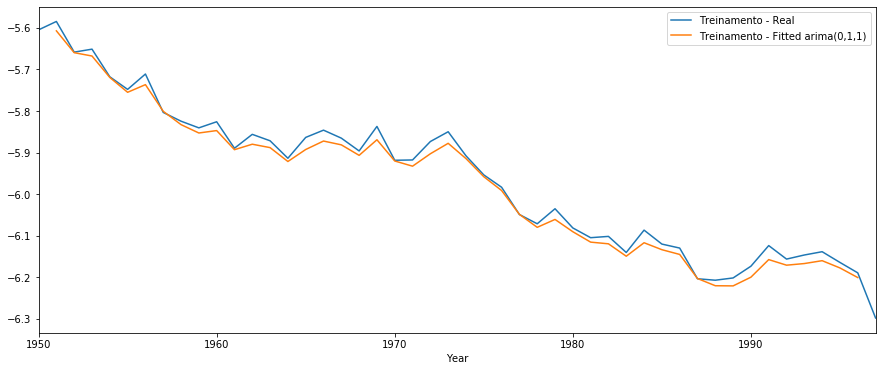

In [28]:
# extração do fit e plotando o gráfico
arima_fit_treino = stepwise_model.predict_in_sample()
arima_fit_treino = incrementar_serie(serie_diff=arima_fit_treino, serie_real=treino)
arima_fit_treino = pd.Series(arima_fit_treino, index = treino[1:].index)
treino.plot(label='Treinamento - Real')
arima_fit_treino.plot(label='Treinamento - Fitted arima(0,1,1)')
plt.legend()
plt.show()

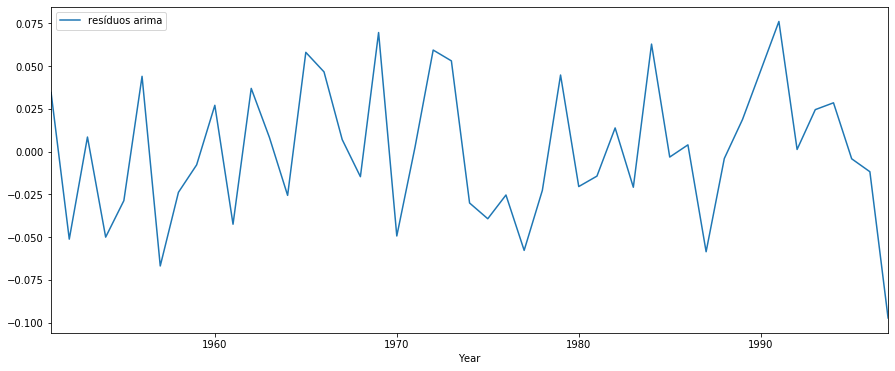

In [29]:
# extração dos resíduos e plotando o gráfico
resid_arima = stepwise_model.resid()
resid_arima = pd.Series(resid_arima, index = treino[1:].index)
resid_arima.plot(label='resíduos arima')
plt.legend()
plt.show()

/home/ggcarvalho/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


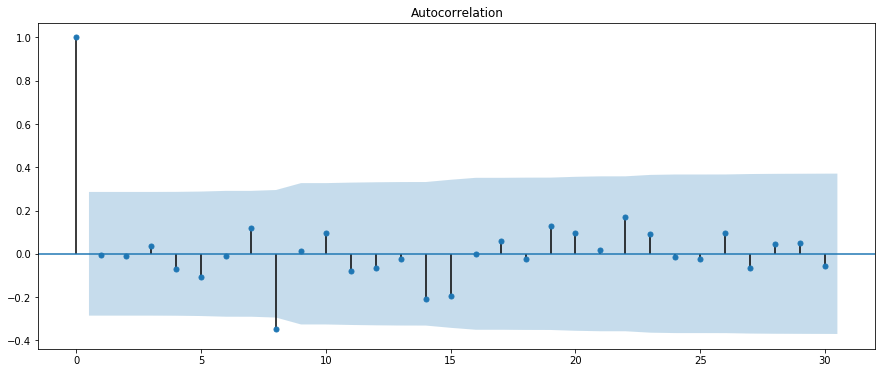

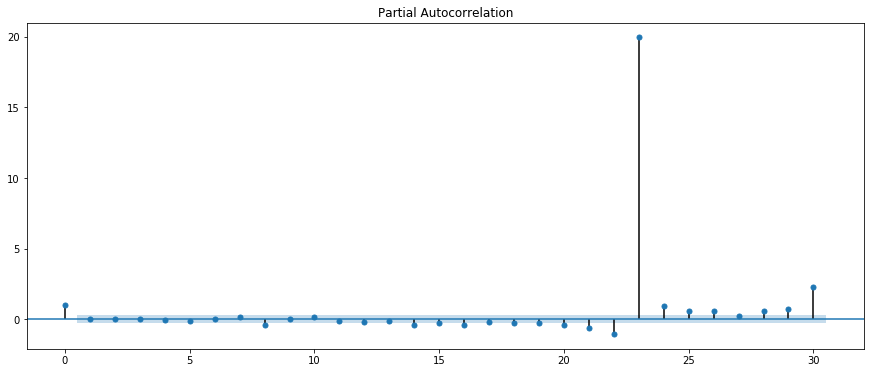

In [30]:
# Análise do autocorrelograma dos resíduos
plot_acf(resid_arima, lags=30)
plot_pacf(resid_arima, lags=30)
plt.show()

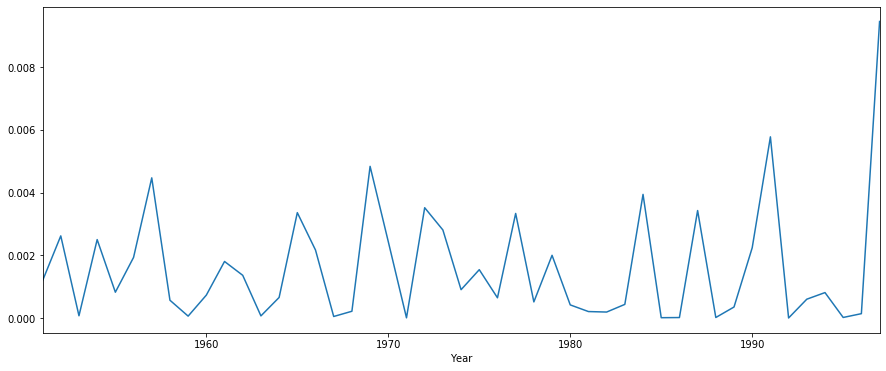

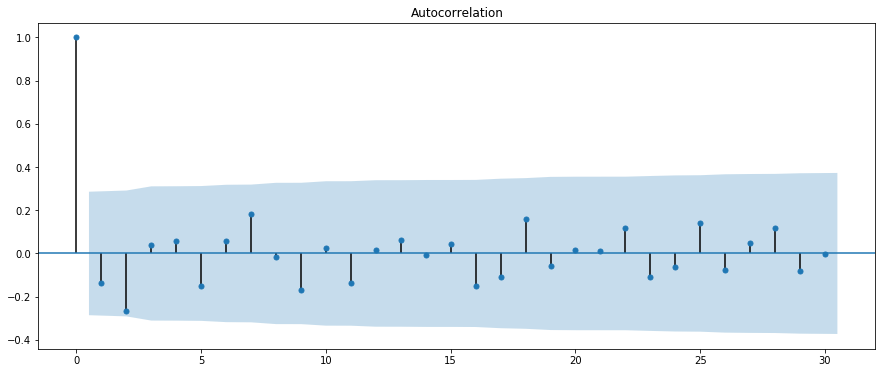

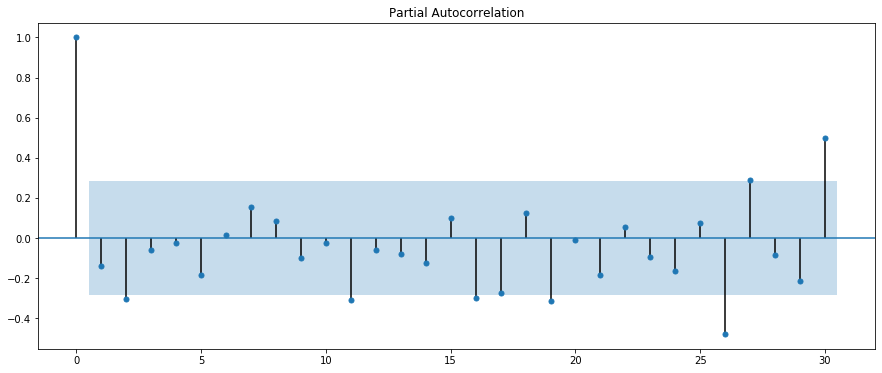

In [31]:
# teste o resíduo ao quadrado
resid_arima2 = resid_arima**2
resid_arima2.plot()
plot_acf(resid_arima2, lags=30)
plot_pacf(resid_arima2, lags=30)
plt.show()

Verifica-se autocorrelação parcial significativa no lag de ordem 2. 

Agora tentaremos rodar uma mlp no resíduo.

### MLP

In [32]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec):
    
    
    neuronios =  [1, 2, 3, 5, 10]    #[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 170, 200]
    func_activation =  ['tanh', 'relu']   #['identity', 'tanh', 'relu']
    alg_treinamento = ['lbfgs', 'sgd', 'adam']#, ['lbfgs','sgd', 'adam']
    max_iteracoes = [10000] #[100, 1000, 10000]
    learning_rate = ['adaptive']  #['constant', 'invscaling', 'adaptive']
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):
                        for qtd_lag in range(1, len(x_train[0]+1)): #variar a qtd de pontos utilizados na janela 
                            
                            print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation[j])


                            for e in range(0,num_exec):
                                mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=func_activation[j], solver=alg_treinamento[l], max_iter = max_iteracoes[m], learning_rate= learning_rate[n])
                                
                                
                                mlp.fit(x_train[:,-qtd_lag:], y_train)
                                predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                                rmse = np.sqrt(MSE(y_val, predict_validation))

                                if rmse < best_result:
                                    best_result = rmse
                                    print('Melhor RMSE:', best_result)
                                    select_model = mlp
                                    qtd_lags_sel = qtd_lag
    
    
    return select_model, qtd_lags_sel

### Aplicação do Sistema Híbrido - ARIMA + MLP

In [33]:
# gerando janelas a partir dos resíduos
# selecionar o modelo MLP com base no teste dos resíduos
# tamanho de janela = 5
# normalizar resid_arima
resid_arima_norm = normalizar_serie(resid_arima)
janelas = gerar_janelas(tam_janela=5, serie=resid_arima_norm)

In [34]:
# testando sem normalizacao
janelas = gerar_janelas(tam_janela=5, serie=resid_arima)

In [35]:
# criar as partições de treinamento, validacao e teste com os dados de treinamento
x_train, y_train, x_test, y_test, x_val, y_val =split_serie_with_lags(serie=janelas, perc_train=0.75, perc_val=0.2)

Particao de Treinamento: 0 30
Particao de Validacao: 30 38
Particao de Teste: 38 41


In [36]:
# treinar MLP
mlp_model, lag_sel = treinar_mlp(x_train, y_train, x_val, y_val, num_exec = 15)

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
Melhor RMSE: 0.040605695723165726
Melhor RMSE: 0.03878554509402894
Melhor RMSE: 0.038708414430014264
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
Melhor RMSE: 0.03866546562646158
Melhor RMSE: 0.03817744273869122
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
Melhor RMSE: 0.03770057712297021
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Q

In [37]:
# teste da mlp
predict_train = mlp_model.predict(x_train[:, -lag_sel:])
predict_val = mlp_model.predict(x_val[:, -lag_sel:])
predict_test = mlp_model.predict(x_test[:, -lag_sel:])

In [38]:
previsoes_train = np.hstack(( predict_train, predict_val))
target_train = np.hstack((y_train, y_val))

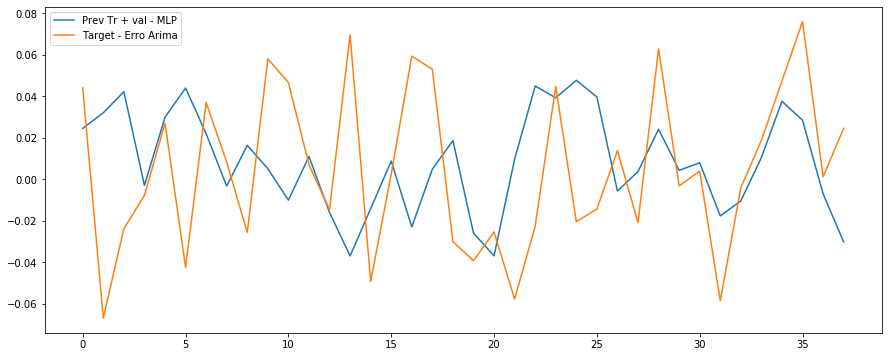

In [39]:
# plotando 
plt.plot(previsoes_train, label = 'Prev Tr + val - MLP')
plt.plot(target_train, label='Target - Erro Arima')
plt.legend(loc='best')
plt.show()

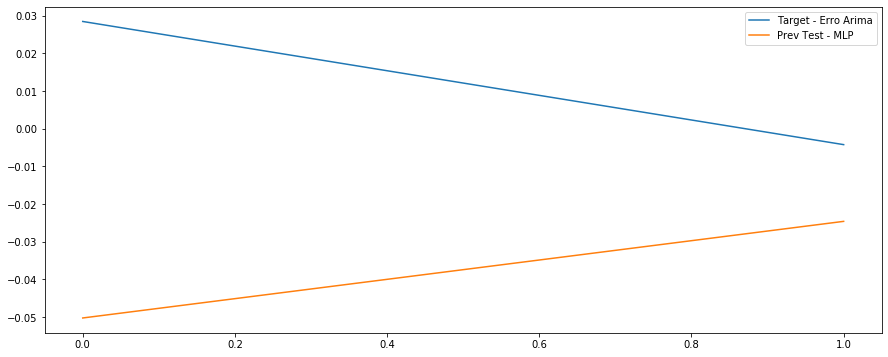

In [40]:
plt.plot(y_test, label='Target - Erro Arima')
plt.plot(predict_test, label = 'Prev Test - MLP')
plt.legend(loc='best')
plt.show()

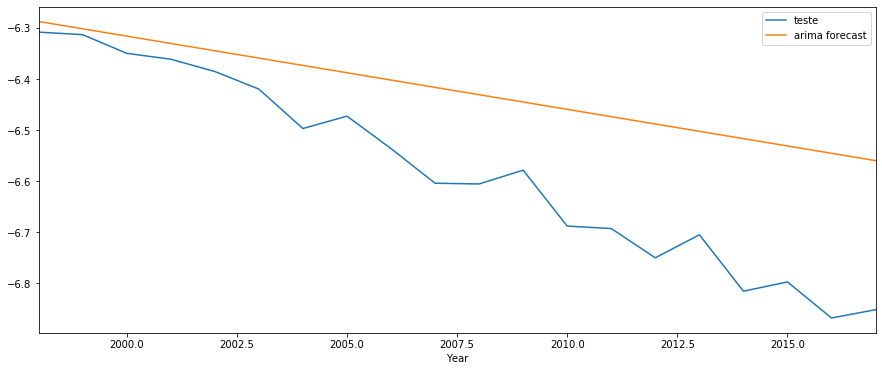

In [41]:
# aplicando arima na série de teste
arima_predict = stepwise_model.predict(n_periods=20)
arima_predict = pd.Series(arima_predict, index = teste.index)
teste.plot(label='teste')
arima_predict.plot(label='arima forecast')
plt.legend()
plt.show()

In [42]:
# calculando RMSE do Arima
rmse_arima = np.sqrt(MSE(teste, arima_predict))
rmse_arima

0.18573157125241335

In [43]:
# extraindo o erro do arima dos dados de teste
erro_arima = arima_predict - teste

In [44]:
# organizar os dados para prever com MLP
# normalizar e depois aplicar mlp_model 
erro_arima_norm = normalizar_serie(erro_arima)
janelas_erro = gerar_janelas(5, erro_arima_norm)
predict_erro_test = mlp_model.predict(janelas_erro[:, -lag_sel:])
predict_erro_test = desnormalizar(predict_erro_test, erro_arima_norm)
predict_erro_test = predict_erro_test.set_index(erro_arima.index[6:])

In [45]:
# testando sem normalizacao
#janelas_erro = gerar_janelas(5, erro_arima)
#predict_erro_test = mlp_model.predict(janelas_erro[:, -lag_sel:])
#predict_erro_test = pd.Series(predict_erro_test, index = erro_arima.index[6:])

In [46]:
# Criar o modelo Z = L + N
z = np.zeros(len(predict_erro_test))
for i in np.arange(0,14):
    z[i]=arima_predict[6:].values[i] + predict_erro_test.values[i]
z = pd.Series(z, index = predict_erro_test.index)

In [47]:
# calcunado o rmse
np.sqrt(MSE(teste[6:], z))

0.34293076424167357

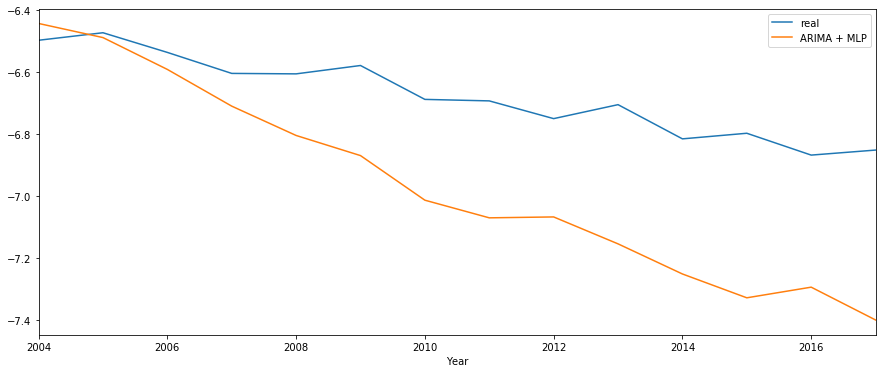

In [48]:
# plotando série
teste[6:].plot(label='real')
z.plot(label='ARIMA + MLP')
plt.legend()
plt.show()

### Conclusão

O modelo ARIMA apresentou um RMSE, para os dados de teste, no valor de 0.1857315800675915. Contudo, quando implementado a MLP, o RMSE aumentou para o valor de 0.19469358562998432. 

Sendo assim, a MLP não melhorou o modelo. Duas possíveis justificativas podem explicar esse fato:

* O logaritmo da taxa de mortalidade apresenta características de um Random Walk;
* O erro de treinamento do ARIMA, que serviu para treinar o modelo MLP, seria uma série sem autocorrelação.
* O tamanho amostral é pequeno.

Vale a pena investigar se outro modelo de machine learning, por exemplo um SVR, conseguiria mapear de forma mais adequada o erro gerado pelo modelo arima. Ademais, seria interessante implementar outra combinação de sistema híbrido, por meio de técnicas como processos gaussianos, análise funcional etc.

### Para correção

#### Pode ser realizado pelo modo iterativo:

A avaliação nos dados de teste tem que ser realizado de forma sequencial. 

1. Previsão pelo Arima um passo a frente
2. calcula o erro do arima
3. incorpora a previsão do arima na série para prever MLP
3. Previsão pela MLP um passo a frente
4. Soma ARIMA + MLP
5. Calula o erro $\hat{Z}_{t+1} - Z_{t+1}$

#### Como realizando previsões de vários passos a frente:

1. Treina um ARIMA
2. Treina uma MLP nos resíduos do ARIMA
3. Previsão do ARIMA: h = 20
4. Previsão por MLP pode ser feita de duas formas: a. 20 saídas ou b. faço previsões do tipo h1 = t+1, h2 = t+2, ..., h20 = t+20 (dando saltos).
